# Tutorial I: information theory applied to fMRI

## Dataset: 
- https://github.com/brincolab/High-Order-interactions/tree/master/dataset/timeseries
- functional magnetic resonance imaging (fMRI) data was obtained at rest from 164 healthy subjects with ages ranging from 10 to 80 years 

## Objectives:

Compute the O-information to characterize redundant and synergistic interaction through three approaches:
- Exhaustively analyzing all the interactions
- Subsampling
- Greedy search algorithm


In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import norm
from scipy.special import psi
import scipy.io as sio
import nibabel as nib
from nilearn import plotting
from itertools import combinations
import random


In [2]:
basefold = "C:\\Users\\rherz\\OneDrive\\Documents\\Projects\\Frankfurt2024\\Tutorials\\dataset\\timeseries\\"
# basefold = "/Users/mgatica/Dropbox/Postdoc_NUL/aging/dataset/timeseries/"
modules = 20 # number of modules
nsubj = 161 #number of participants
timepoints = 159 #number of time points

data =  np.zeros((nsubj,modules,timepoints))

for participant in range(nsubj):
    ts = np.loadtxt(basefold+"ts_m20_p%.3i.txt"%(participant+1))
    data[participant,:,:] = ts[:,:159]#We recommend truncating all the data to the same number of samples. In this example 15

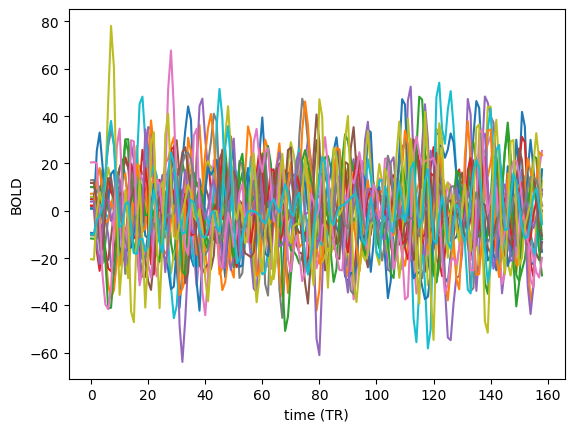

In [3]:
# Checking that loading works. Plotting one subjec
plt.figure()
plt.plot(data[10,:,:].T)#Plotting the BOLD for one subject
plt.xlabel("time (TR)")
plt.ylabel("BOLD")
plt.show()

# Objective 1: Exhaustively analyzing all the interactions using Gaussian Copula 

In [3]:
# Defining functions for gaussian copula and high-order interactions
def data2gaussian(data):
    """
    Transforms 'data' (T samples x N dimension matrix) to Gaussian with 0 mean and 1 sd
    using empirical copulas

    INPUT:
    data = T samples x N variables matrix

    OUTPUT:
    gaussian_data = T samples x N variables matrix with the Gaussian copula transformed data
    covmat = N x N covariance matrix of Gaussian copula transformed data.
    """
    T, N = data.shape
    # Sort data and keep sorting indexes
    sortid = np.argsort(data, axis=0)
    # Sorting indexes
    copdata = np.argsort(sortid, axis=0)   
    # Normalization to have data in [0,1]
    copdata = copdata / (T + 1)  
    # Uniform data to Gaussian data
    gaussian_data = norm.ppf(copdata)  
    # Removing inf
    gaussian_data[np.isinf(gaussian_data)] = 0
    # Covariance matrix
    covmat = np.cov(gaussian_data, rowvar=False)   
    return gaussian_data, covmat


def gaussian_ent_biascorr(N, T):
    """
    Computes the bias corrector for the entropy estimator based on the covariance matrix of Gaussians.

    INPUTS:
    N = Number of dimensions
    T = Sample size

    OUTPUT:
    biascorr = bias corrector value
    """
    psiterms = psi((T - np.arange(1, N + 1)) / 2)
    biascorr = 0.5 * (N * np.log(2 / (T - 1)) + np.sum(psiterms))
    
    return biascorr

def soinfo_from_covmat(covmat, T):
    """
    Computes the O-Information and S-Information of Gaussian data given their covariance matrix.

    INPUTS:
    covmat = N x N covariance matrix
    T = length data

    OUTPUT:
    oinfo (O-Information)
    sinfo (S-Information) of the system with covariance matrix covmat.
    """
    ent_fun = lambda x, y: 0.5 * np.log(((2 * np.pi * np.exp(1)) ** x) * y)
    
    N = covmat.shape[0]
    emp_det = np.linalg.det(covmat)  # determinant
    single_vars = np.diag(covmat)  # variance of single variables
    
    # Bias correctors for N, (N-1), and one Gaussian variable
    biascorrN = gaussian_ent_biascorr(N, T)
    biascorrNmin1 = gaussian_ent_biascorr(N-1, T)
    biascorr_1 = gaussian_ent_biascorr(1, T)
    
    # Computing estimated measures for multi-variate Gaussian variables
    tc = np.sum(ent_fun(1, single_vars) - biascorr_1) - (ent_fun(N, emp_det) - biascorrN)
    
    Hred = 0
    reduce_x = lambda x, covmat: covmat[np.ix_(np.arange(N) != x, np.arange(N) != x)]
    for red in range(N):
        Hred += ent_fun(N-1, np.linalg.det(reduce_x(red, covmat))) - biascorrNmin1
    
    dtc = Hred - (N-1) * (ent_fun(N, emp_det) - biascorrN)
    oinfo = tc - dtc
    sinfo = tc + dtc
    
    return oinfo, sinfo



def high_order(data, n, opt="exhaustive"):
    """
    Code description: Function to compute S-Information, O-Information, and characterize the High-order interactions among n variables governed by Redundancy or Synergy.

    Input: - 'data': Matrix with dimensionality (N,T), where N is the number of brain regions or modules, and T is the number of samples.
           - 'n': number of interactions or n-plets. n must be greater or equal, and if n=3, then the interactions is among triplets. 
    
    Output: - 'Red': Matrix with dimension (Npatients,Modules), with the redundancy values per patient and per module
            - 'Syn': Matrix with dimension (Npatients,Modules), with the synergy values per patient and per module
            - 'Oinfo': O-Information for all the n-plets.
            - 'Sinfo': S-Information for all the n-plets
    """
    Modules = data.shape[0]
    Red = np.zeros(Modules)  # initialize matrix for redundancy values
    Syn = np.zeros(Modules)  # initialize matrix for synergy values

    if opt == "exhaustive":
        nplets = list(combinations(range(Modules), n))  # generate combinations of n modules
    elif opt == "subsampling":
        all_nplets = list(combinations(range(Modules), n))  # generate combinations of n modules
        subsampled_triplets = random.sample(all_nplets, N_subsample) #subsampling N n-plets
        nplets = subsampled_triplets
    
    Oinfo = np.zeros(len(nplets))  # vector to store O-Information for each n-tuple
    Sinfo = np.zeros(len(nplets))  # vector to store S-Information for each n-tuple

    dataNorm = data - np.mean(data, axis=1, keepdims=True)  # normalize data per module

    # Estimate covariance matrix from normalized data
    gaussian_data, est_covmat = data2gaussian(dataNorm.T)

    i = 0
    for npletIndices in nplets:
        sub_covmat = est_covmat[np.ix_(npletIndices, npletIndices)]
        est_oinfo, est_sinfo = soinfo_from_covmat(sub_covmat, dataNorm.shape[1])
        Oinfo[i] = est_oinfo
        Sinfo[i] = est_sinfo
        i += 1

    for module in range(Modules):
        modRow = [idx for idx, tpl in enumerate(nplets) if module in tpl]
        Oinfo_module = Oinfo[modRow]
        Red[module] = np.mean(Oinfo_module[Oinfo_module > 0])
        Syn[module] = np.mean(np.abs(Oinfo_module[Oinfo_module < 0]))

    Syn[np.isnan(Syn)] = 0
    Red[np.isnan(Red)] = 0

    return Oinfo, Sinfo, Red, Syn

(159, 20)
(159, 20)
(20, 20)


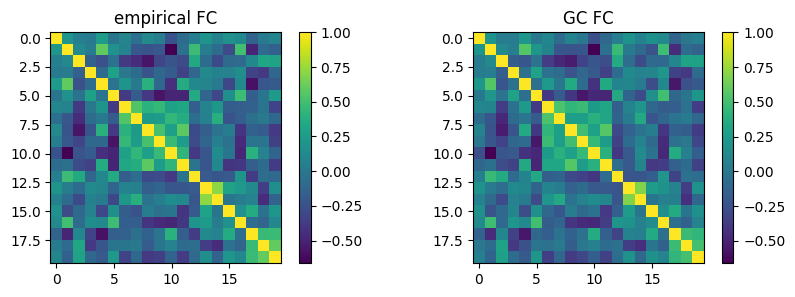

In [4]:
# Example usage of Gaussian Copula transformed data
data_test = data[10,:,:].T # Select one subject
print(np.shape(data_test)) #print the shape
gaussian_data, covmat = data2gaussian(data_test) #transform the data into the Gaussian copula space
print(np.shape(gaussian_data))
print(np.shape(covmat))

#Ploting the correlation matrices (FC) pre and post transformation
plt.figure(figsize=(10,3))
plt.subplot(121)
plt.imshow(np.corrcoef(data_test.T));plt.colorbar()
plt.title("empirical FC")
plt.subplot(122)
plt.imshow(np.corrcoef(gaussian_data.T));plt.colorbar()
plt.title("GC FC")

plt.show()

## Computing the high-order quantities 

$TC(X^n) = \sum_{j=1}^n H(X_j) - H(X^n)$ 

$DTC(X^n) = H(X^n) - \sum_{j=1}^n H(X_j|X^n_{-j})$

$\Omega_n (X_1,\dots , X_n) = TC - DTC = (n - 2) H(X_1,\dots , X_n) + \sum_{j=1}^n [H(X_j) - H(X_1,\dots , X_{j-1},X_{j+1},\dots, X_n)]$

$S_n(X_1,\dots , X_n) = TC + DTC $

$\Omega_n(X_1,\dots , X_n) >0$: Redundancy, 

$\Omega_n(X_1,\dots , X_n) <0$: Synergy


### Computing redundancy and synergy for triplets in younger vs older subjects 

<img src="aging.png" width="400px">


In [5]:
n = 3 #interaction order (triplets in this case)

Red = np.zeros((nsubj,modules))  # create matrix for redundancy values
Syn = np.zeros((nsubj,modules)) # create matrix for synergy values

nplets = list(combinations(range(modules), n))  # generate combinations of n=3 modules
Oinfo = np.zeros((nsubj,len(nplets)))  # vector to store O-Information for each n-plets
Sinfo = np.zeros((nsubj,len(nplets)))# vector to store S-Information for each n-plets


for patient in range(nsubj):
    dataPatient = data[patient,:,:]  #load data per subject
    #print(np.shape(dataPatient))
    Oinfo[patient,:], Sinfo[patient,:], Red[patient,:], Syn[patient,:] = high_order(dataPatient, n,"exhaustive")#Computing the HOI

# Call the high_order function for triplets (n=3)

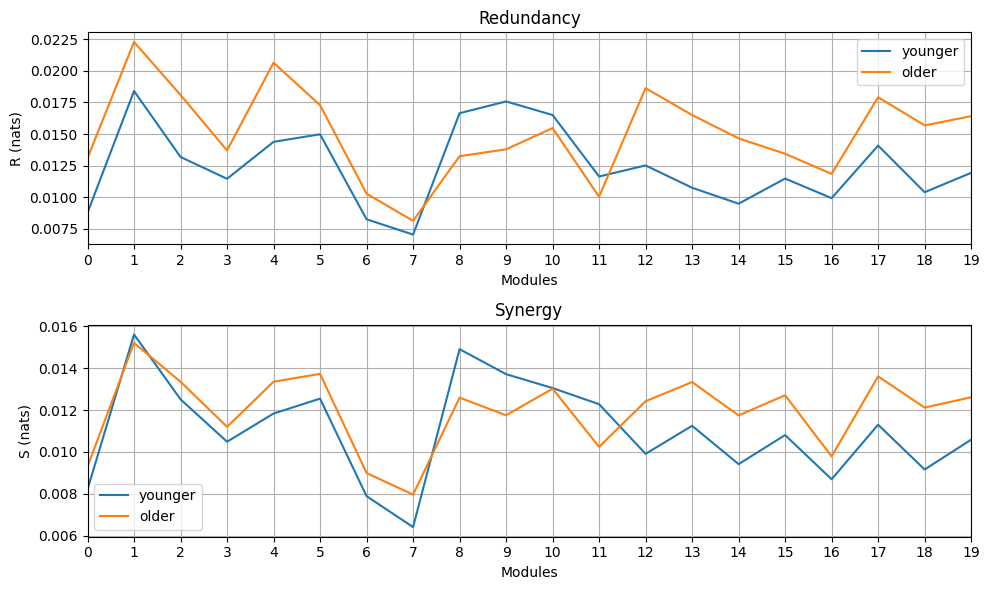

In [6]:
#Loading the age vector
ages = sio.loadmat("C:\\Users\\rherz\\OneDrive\\Documents\\Projects\\Frankfurt2024\\Tutorials\\dataset\\ages_up.mat")["ages_up"][0]
I1 = ages<60 #younger group
I2 = ages>=60 #older group

plt.figure(figsize=(10, 6))

plt.subplot(2, 1, 1)
plt.plot(np.mean(Red[I1,:], axis=0))
plt.plot(np.mean(Red[I2,:], axis=0))
plt.title('Redundancy')
plt.xlabel('Modules')
plt.ylabel('R (nats)')
plt.grid(True)
plt.xticks(np.arange(modules))
plt.xlim(0, modules - 1)
plt.tight_layout()
plt.legend(["younger","older"])


plt.subplot(2, 1, 2)
plt.plot(np.mean(Syn[I1,:], axis=0))
plt.plot(np.mean(Syn[I2,:], axis=0))
plt.title('Synergy')
plt.xlabel('Modules')
plt.ylabel('S (nats)')
plt.grid(True)
plt.xticks(np.arange(modules))
plt.xlim(0, modules - 1)
plt.tight_layout()
plt.legend(["younger","older"])
plt.show()

In [7]:
# Function for plotting brains
def brain_hoi(atlas, values,title):
    # Load the NIfTI atlas
    #atlas_path = '/Users/mgatica/Dropbox/Postdoc_NUL/Human_PhiID_modelling/desikan.nii'  # Replace with your atlas path
    atlas_img = nib.load(atlas)
    atlas_data = atlas_img.get_fdata()
    
    # Vector with values to plot (length should be N, the number of ROIs)
    #values = np.random.rand(int(np.max(atlas_data)))  # Example vector, replace with your actual data
    
    # Create an empty image to store the values
    new_data = np.zeros_like(atlas_data)
    
    # Map the vector values to the corresponding ROIs
    for i in range(1, len(values) + 1):  # assuming ROI indices start at 1
        new_data[atlas_data == i] = values[i - 1]
    
    # Create a new NIfTI image
    new_img = nib.Nifti1Image(new_data, affine=atlas_img.affine, header=atlas_img.header)
    
    # Plot the image
    plotting.plot_stat_map(new_img, display_mode='ortho', title=title, cut_coords=(-13,0,11),cmap= 'coolwarm')
    plt.show()

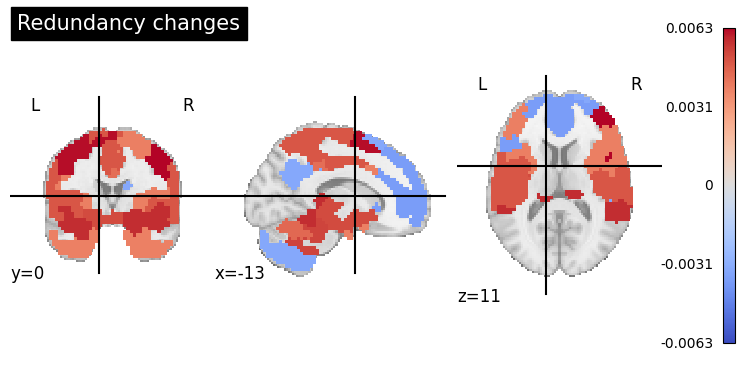

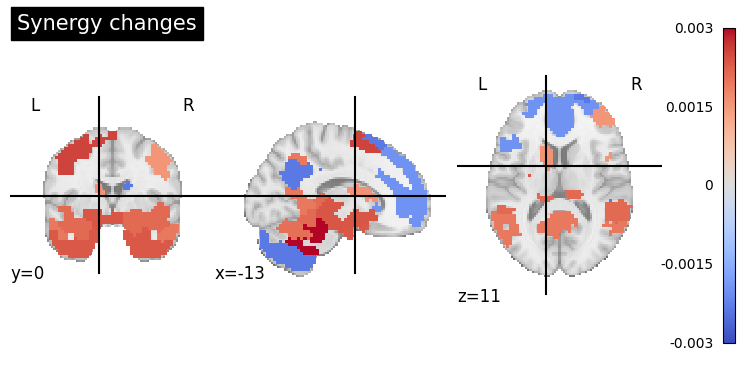

In [8]:
atlas = "BHA_atlas.nii"
diff_red = np.mean(Red[I2,:], axis=0) - np.mean(Red[I1,:], axis=0) #older minus younger (redundancy)
diff_red[np.abs(diff_red)<0.003] = 0 
brain_hoi(atlas, diff_red,"Redundancy changes")

diff_syn = np.mean(Syn[I2,:], axis=0) - np.mean(Syn[I1,:], axis=0) #older minus younger (synergy)
diff_syn[np.abs(diff_syn)<0.0015] = 0 
brain_hoi(atlas, diff_syn,"Synergy changes")

# Objective 2: Subsampling N = 50 triplets

In [9]:
N_subsample = 50

Red_subsample = np.zeros((nsubj,modules))  # create matrix for redundancy values
Syn_subsample = np.zeros((nsubj,modules)) # create matrix for synergy values


for patient in range(nsubj):
    dataPatient = data[patient,:,:]  #load data per subject
    _, _, Red_subsample[patient,:], Syn_subsample[patient,:] = high_order(dataPatient, n,"subsampling")#Computing the HOI

C:\Users\rherz\.conda\envs\thoi\Lib\site-packages\numpy\core\fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
C:\Users\rherz\.conda\envs\thoi\Lib\site-packages\numpy\core\_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


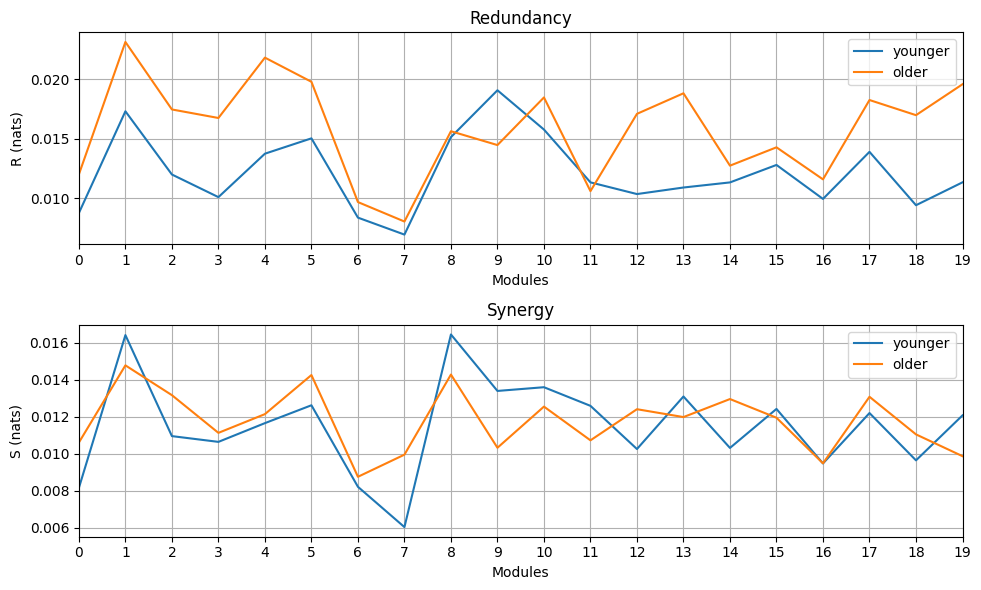

In [17]:
plt.figure(figsize=(10, 6))

plt.subplot(2, 1, 1)
plt.plot(np.mean(Red_subsample[I1,:], axis=0))
plt.plot(np.mean(Red_subsample[I2,:], axis=0))
plt.title('Redundancy')
plt.xlabel('Modules')
plt.ylabel('R (nats)')
plt.grid(True)
plt.xticks(np.arange(modules))
plt.xlim(0, modules - 1)
plt.tight_layout()
plt.legend(["younger","older"])


plt.subplot(2, 1, 2)
plt.plot(np.mean(Syn_subsample[I1,:], axis=0))
plt.plot(np.mean(Syn_subsample[I2,:], axis=0))
plt.title('Synergy')
plt.xlabel('Modules')
plt.ylabel('S (nats)')
plt.grid(True)
plt.xticks(np.arange(modules))
plt.xlim(0, modules - 1)
plt.tight_layout()
plt.legend(["younger","older"])
plt.show()

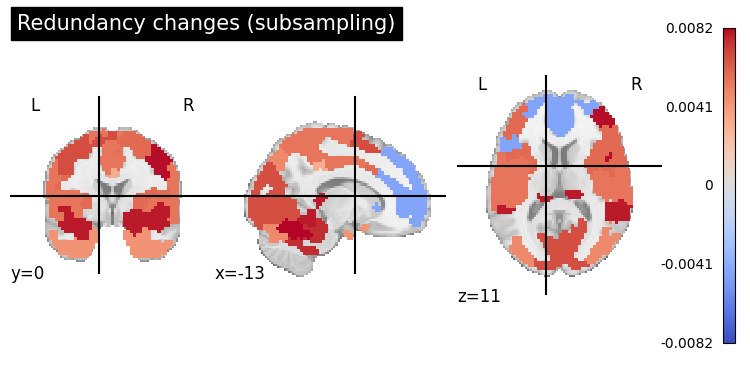

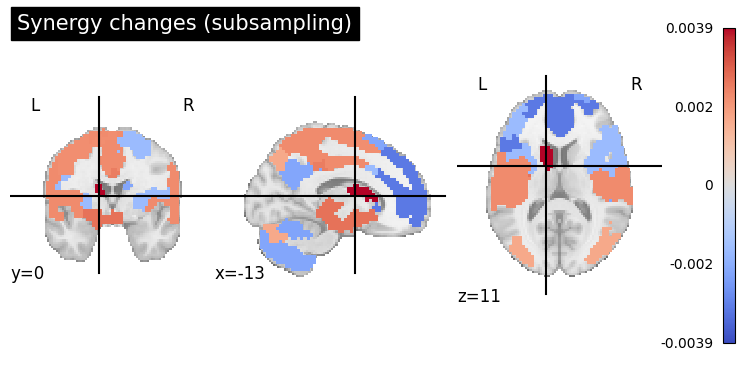

In [18]:
atlas = "BHA_atlas.nii"
diff_red_subsampling = np.mean(Red_subsample[I2,:], axis=0) - np.mean(Red_subsample[I1,:], axis=0) #older minus younger (redundancy)
diff_red_subsampling[np.abs(diff_red_subsampling)<0.003] = 0 
brain_hoi(atlas, diff_red_subsampling,"Redundancy changes (subsampling)")

diff_syn_subsample = np.mean(Syn_subsample[I2,:], axis=0) - np.mean(Syn_subsample[I1,:], axis=0) #older minus younger (synergy)
diff_syn_subsample[np.abs(diff_syn_subsample)<0.0015] = 0 
brain_hoi(atlas, diff_syn_subsample,"Synergy changes (subsampling)")